In [5]:
# example_effective_area.ipynb
# Authors: Stephan Meighen-Berger
# Example how to get a rudimentary effective area

In [6]:

import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# matplotlib widget

In [3]:
# Designed for the publicly available pone_one data set.
example_set = ak.from_parquet('/home/unimelb.edu.au/smeighenberg/data/triangle_pone_one/', lazy=True)

In [4]:
# The events are split into three parts:
#   - lepton: the light from the generated lepton
#   - hadron: the light produced from the associated hadronic cascade (at production point)
#   - total: the light from both parts
# Each of these fields is formatted the same way
example_set.fields

['event_id', 'mc_truth', 'primary_lepton_1', 'primary_hadron_1', 'total']

In [5]:
# Example for one event
event_id = 0
# The sensors hit
print("Total number of hits:")
print(len(example_set.total.sensor_id[event_id]))
print('The hit sensors: ')
print(example_set.total.sensor_id[event_id])
print('Their associated strings')
print(example_set.total.sensor_string_id[event_id])
print('The hit times')
print(example_set.total.t[event_id])

Total number of hits:
14
The hit sensors: 
[29, 29, 29, 29, 29, 29, 6, 7, 8, 8, 8, 9, 47, 49]
Their associated strings
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2]
The hit times
[490, 489, 493, 512, 510, 581, 390, 214, 249, 248, 246, 439, 292, 478]


In [6]:
# Getting the detector
pos = []
with open('/home/unimelb.edu.au/smeighenberg/Projects/hebe/hebe/data/pone_triangle-geo') as geo_in:
    read_lines = geo_in.readlines()
    modules_i = read_lines.index("### Modules ###\n")   
    for line in read_lines[modules_i+1:]:
        line = line.strip("\n").split("\t")
        pos.append(
            np.array([float(line[0]), float(line[1]),
            float(line[2])]))
    det = np.array(pos)
det = det - np.mean(det, axis=0)

In [7]:
e_bins = np.logspace(2., 6., 41)

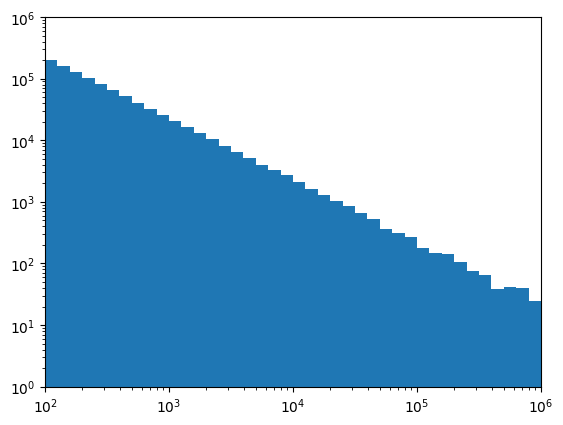

In [8]:
plt.hist(example_set.mc_truth.injection_energy, bins=e_bins)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e2, 1e6)
plt.ylim(1., 1e6)
plt.show()

In [9]:
bin_ids = np.digitize(example_set.mc_truth.injection_energy, bins=e_bins)

In [10]:
unique_ids = np.unique(bin_ids)

In [11]:
hit_bins = np.arange(start=0., stop=1e3, step=1)

In [12]:
all_hits = []
for u_id in unique_ids:
    id_mask = bin_ids == u_id
    events_hits = example_set.total[id_mask].t
    all_hits.append(np.array([len(event)  for event in events_hits]))

In [13]:
all_counts = []
for hits in all_hits:
    counts, _ = np.histogram(hits, hit_bins, density=True)
    all_counts.append(counts)

/home/unimelb.edu.au/smeighenberg/envs/hebe/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


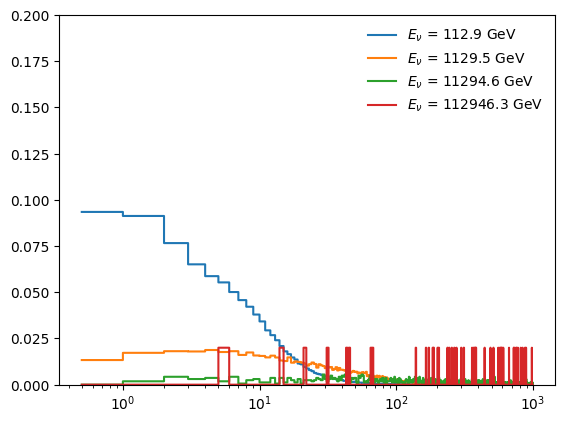

In [14]:
e_id = 0
plt.step((hit_bins[1:] + hit_bins[:-1]) / 2., all_counts[e_id], where='mid', label=r'$E_\nu$ = %.1f GeV' % ((e_bins[1:] + e_bins[:-1]) / 2.)[e_id])
e_id = 10
plt.step((hit_bins[1:] + hit_bins[:-1]) / 2., all_counts[e_id], where='mid', label=r'$E_\nu$ = %.1f GeV' % ((e_bins[1:] + e_bins[:-1]) / 2.)[e_id])
e_id = 20
plt.step((hit_bins[1:] + hit_bins[:-1]) / 2., all_counts[e_id], where='mid', label=r'$E_\nu$ = %.1f GeV' % ((e_bins[1:] + e_bins[:-1]) / 2.)[e_id])
e_id = 30
plt.step((hit_bins[1:] + hit_bins[:-1]) / 2., all_counts[e_id], where='mid', label=r'$E_\nu$ = %.1f GeV' % ((e_bins[1:] + e_bins[:-1]) / 2.)[e_id])
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0., 0.2)
plt.legend(frameon=False)
plt.show()

In [15]:
def fraction(data, hit_bins, hit_cut):
    fraction = []
    for counts in data:
        total = np.sum(counts)
        cut_id = (np.abs(hit_bins - hit_cut)).argmin()
        surv_counts = counts[cut_id:]
        survived = np.sum(surv_counts)
        fraction.append(survived)
    return np.array(fraction)

In [35]:
# Rudimentary Weight Construction
avogadro = 6.022 * 1e23
water_weight = 18.
water_density = 1.
pone_length =  500
cc_xsec = np.loadtxt(
    "/home/unimelb.edu.au/smeighenberg/data/Mean_nu_xsec_cc.csv",
    delimiter=",", dtype=float
)
cc_xsec = cc_xsec[cc_xsec[:, 0].argsort()]
spl_cc_xsec = UnivariateSpline(cc_xsec[:, 0], water_weight / (cc_xsec[:, 1] * avogadro * water_density * 1e-38) * 1e-2, k=1, s=0, ext=3)  # Units m^2
spl_int_prob = UnivariateSpline(cc_xsec[:, 0], pone_length / spl_cc_xsec(cc_xsec[:, 0]), k=1, s=0, ext=3)

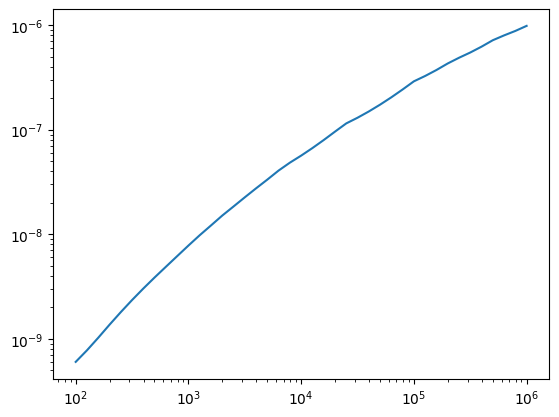

In [36]:
plt.plot(e_bins, spl_int_prob(e_bins))
plt.yscale('log')
plt.xscale('log')

In [85]:
hit_cuts = [0., 8, 60.]
fracs = []
for cut in hit_cuts:
    fracs.append(
        fraction(all_counts, (hit_bins[1:] + hit_bins[:-1]) / 2., cut)
    )

In [86]:
# IceCube results
ice_nohit_xsec = np.loadtxt(
    "/home/unimelb.edu.au/smeighenberg/data/icecube_nocut.csv",
    delimiter=",", dtype=float
)
ice_nohit_xsec = ice_nohit_xsec[ice_nohit_xsec[:, 0].argsort()]
ice_60hit_xsec = np.loadtxt(
    "/home/unimelb.edu.au/smeighenberg/data/icecube_60cut.csv",
    delimiter=",", dtype=float
)
ice_60hit_xsec = ice_60hit_xsec[ice_60hit_xsec[:, 0].argsort()]
ice_all_low = np.loadtxt(
    "/home/unimelb.edu.au/smeighenberg/data/icecube_allsky_low.csv",
    delimiter=",", dtype=float
)
ice_all_low = ice_all_low[ice_all_low[:, 0].argsort()]
icelow = UnivariateSpline(ice_all_low[:, 0], ice_all_low[:, 1], k=1, s=0, ext=3)
ice_all_high = np.loadtxt(
    "/home/unimelb.edu.au/smeighenberg/data/icecube_allsky_high.csv",
    delimiter=",", dtype=float
)
ice_all_high = ice_all_high[ice_all_high[:, 0].argsort()]
icehigh = UnivariateSpline(ice_all_high[:, 0], ice_all_high[:, 1], k=1, s=0, ext=3)
ice_8hit_xsec = np.loadtxt(
    "/home/unimelb.edu.au/smeighenberg/data/icecube_smt8.csv",
    delimiter=",", dtype=float
)
ice_8hit_xsec = ice_8hit_xsec[ice_8hit_xsec[:, 0].argsort()]

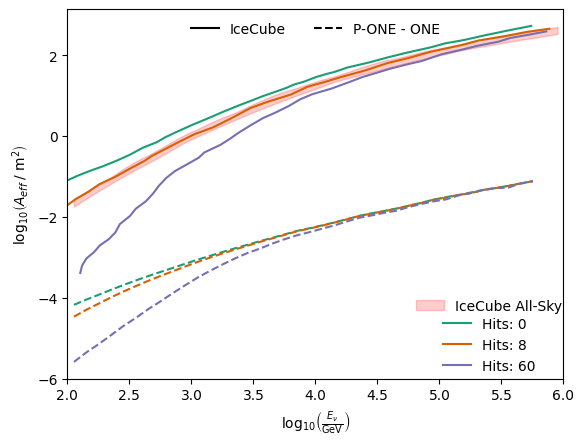

In [97]:
det_area = 1e3 * 1e2
colors = ['#1b9e77', '#d95f02', '#7570b3']
plt.plot(ice_nohit_xsec[:, 0], ice_nohit_xsec[:, 1], color=colors[0])
plt.plot(ice_8hit_xsec[:, 0], ice_8hit_xsec[:, 1], color=colors[1])
plt.plot(ice_60hit_xsec[:, 0], ice_60hit_xsec[:, 1], color=colors[2])
plt.fill_between(np.log10((e_bins[1:] + e_bins[:-1]) / 2.), icelow(np.log10((e_bins[1:] + e_bins[:-1]) / 2.)), icehigh(np.log10((e_bins[1:] + e_bins[:-1]) / 2.)), color='r', alpha=0.2)
for id_frac, frac in enumerate(fracs):
    plt.plot(np.log10((e_bins[1:] + e_bins[:-1]) / 2.), np.log10(frac * det_area * spl_int_prob(((e_bins[1:] + e_bins[:-1]) / 2.))), ls='--', color=colors[id_frac])
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(2, 6)
icecube = Line2D([0], [0], label=r'IceCube', color='k')
pone = Line2D([0], [0], label=r'P-ONE - ONE', color='k', ls='--')
handles = [icecube, pone]
hit0 = Line2D([0], [0], label=r'Hits: 0', color=colors[0])
hit8 = Line2D([0], [0], label=r'Hits: 8', color=colors[1])
hit60 = Line2D([0], [0], label=r'Hits: 60', color=colors[2])
patch = mpatches.Patch(color='r', label='IceCube All-Sky', alpha=0.2)
handles2 = [hit0, hit8, hit60]
lgd2 = plt.legend(loc=9, handles=handles, bbox_to_anchor=(0.5, 1.), ncol=2, frameon=False)
lgd3= plt.legend(loc=9, handles=[patch], bbox_to_anchor=(0.85, 0.25), ncol=1, frameon=False)
lgd1= plt.legend(loc=9, handles=handles2, bbox_to_anchor=(0.85, 0.2), ncol=1, frameon=False)
plt.gca().add_artist(lgd2)
plt.gca().add_artist(lgd3)
plt.xlabel(r'$\mathrm{log}_{10}\left(\frac{E_\nu}{\mathrm{GeV}}\right)$')
plt.ylabel(r'$\mathrm{log}_{10} \left(A_{eff}\;/\;\mathrm{m}^2\right)$')
plt.savefig('aeff_comp.png', facecolor='white', dpi=250)
plt.show()

In [47]:
r = 1. * np.sqrt(3)
vol = 4./3. * r**3. * np.pi

In [48]:
1. / vol

0.04594407461848268

In [51]:
5e-2**2. * 1. / vol

0.00011486018654620673

In [5]:
10**(-23.3) / 10**(-23.5)

1.584893192461111

In [4]:
10**(-23.5)

3.1622776601683795e-24

In [6]:
np.sqrt(10/3)

1.8257418583505538

In [7]:
10**(-24.5)

3.1622776601683796e-25

In [8]:
10**(-23.5) / 10**(-24.5)

10.0

In [7]:
np.log10(10**(-24.3) / 1.4)

-24.44612803567824